# TF acs-2 fluorescence

In [12]:
%matplotlib inline
import os
import sys
import tifffile as tiff
import pandas as pd
import matplotlib
# For visualising
#matplotlib.use('MacOSX') 
# For saving
#matplotlib.use('Agg') 
matplotlib.use('MacOSX') #TkAgg
import matplotlib.pyplot as plt

import numpy as np
import itertools as IT
import time
import glob
import skimage
from skimage import io as skio
from skimage import color

sys.path.append("./src")
from utilities import *

#plt.interactive(True)
matplotlib.rcParams.update({'font.size': 12})
np.set_printoptions(precision=3)


In [27]:
os.chdir("/Users/Povilas/Dropbox/Projects/Metformin_TF_acs-2/")
sourceloc = "Users/Povilas/Dropbox/Projects/Metformin_TF_acs-2/"

# os.chdir("/home/pnorv/Dropbox/Projects/Metformin_TF_acs-2/")
# sourceloc = "home/pnorv/Dropbox/Projects/Metformin_TF_acs-2/"

odir="."

### Settings

#step = 0.001
#levels = ["{0:.3f}".format(lvl) for lvl in np.arange(0, 1 + step, step)]


### Select random file

files=glob.glob("./Rep1*/*/crp metf TF4.tiff")

fl=files[0]


rep,fol,filt=fl.split('/')[1:]
fil=filename(filt)[1]

print fl


./Rep1_23-8-17/crp metf/crp metf TF4.tiff


FWHM: 0.0038254839657, mu: 0.0456182637146, SD: 0.00162453346436


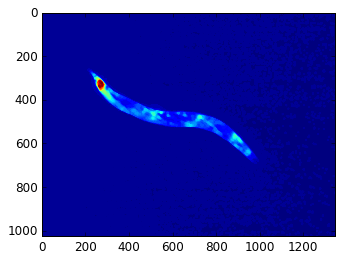

In [28]:
### Load image

image = tiff.imread(fl)

imghsv = color.rgb2hsv(image)
imgrgb = img_as_float(image)

gray = color.rgb2gray(image)
image_rescale=exposure.rescale_intensity(image)

#Image dimensions
image.shape

### Label worms
image_jet=jetimage(gray)

#plt.imshow(image_jet)

v = imghsv[:, :, 2]

# Filtering noise
dv = rank.median(v, disk(3)) / 255.0
#Expanding 
comb = opening(dv, selem=disk(5))

v1D = np.around(v.ravel(), 3)
ftable = np.array(freqtable(v1D))
ftable = ftable[np.argsort(ftable[:, 0])]
X, Y, mu, sd = fitgauss(ftable[:, 0], ftable[:, 1])

#Save image
skio.imsave('{}_{}_{}_adjusted_RGB.tiff'.format(rep,fol,fil),jetimage(comb))

plt.imshow(comb)

Threshold: 0.0520, Worm size: 53604 Image covered: 3.89%


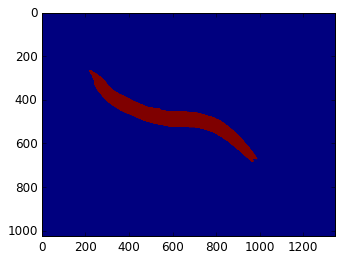

In [29]:
hthr=mu + sd * 0.5

umarks=[0]
wsize=0
imgprc=100

iter=0
total=np.sum(comb >0)

hthri=0.04
step=0.001

#wsize < 45000 or wsize > 55000 or 
while (wsize < 40000 or wsize > 55000 or imgprc<3 or imgprc>5) and iter<100 and hthri<0.06:
    markers = np.zeros_like(comb)
    # Mark background
    imgprc=np.float(np.sum(comb > hthri)*100)/total
    
    markers[comb > hthri] = 2
    umarks=np.unique(markers)
    wsize=np.count_nonzero(markers[markers==2])
    #print("Threshold: {:.4f}, Worm size: {:d} Image covered: {:.2f}%".format(hthri,wsize,imgprc))
    hthri+=step
    iter+=1

markers[comb == 0] = 1

print("Threshold: {:.4f}, Worm size: {:d} Image covered: {:.2f}%".format(hthri,wsize,imgprc))
plt.imshow(markers)

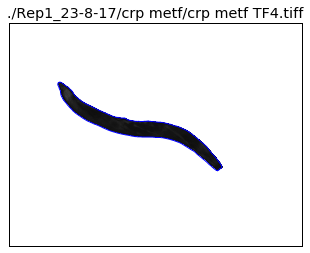

In [30]:
distance = ndi.distance_transform_edt(markers)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=markers)
markersmaxi = ndi.label(local_maxi)[0]
segmentation = watershed(distance, markersmaxi, mask=markers)
segmentation_fill = ndi.binary_fill_holes(segmentation)
labeled_worms, _ = ndi.label(segmentation_fill)
#plt.imshow(labeled_worms)

for w in list(np.unique(labeled_worms)):
    # print labeled_worms[labeled_worms==w].shape[0]
    if labeled_worms[labeled_worms == w].shape[0] < 1000:
        labeled_worms[labeled_worms == w] = 0
        
labeled_worms = opening(labeled_worms, selem=disk(10))

wormind = list(np.unique(labeled_worms))
worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}



row=0
col=0

fig, axes = plt.subplots(nrows=1)#, ncols=1, figsize=(6, 3), dpi=300
#fig.suptitle('{}-{}'.format(replicate, plate), fontsize=40)
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=2, wspace=0.5, hspace=0.1)


ax=axes#[row,col]

plotcontours(imgrgb,ax,labeled_worms,fl,plotlabels=False)


# fig.tight_layout()


# fig.savefig('test.pdf', bbox_inches='tight')
# plt.close(fig)


plt.show()

array([0, 1], dtype=int32)

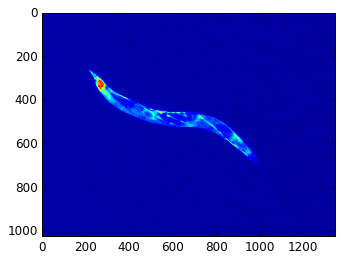

In [43]:
plt.imshow(image[:,:,2])

In [107]:
worm=1
np.sum(image[labeled_worms==worm,:])/np.sum(np.isin(labeled_worms, worm))

64.88639485220794

In [108]:
255*3

765

In [92]:
np.sum(labeled_worms[labeled_worms==worm])

53149

In [124]:
filesel=glob.glob('./Rep1*/crp metf/*.tiff')
ofig='Rep1_crp_metf_test.pdf'
otbl='CRP_test_results.csv'

header=['Replicate', 'Replicate folder', 'Folder', 'File', 'Worm','W_N','W_Sum','W_Mean','B_N','B_Sum','B_Mean']

In [125]:
# rndsel=np.random.randint(len(allfiles)-1,size=5)
# filesel=[ allfiles[i] for i in rndsel ]

ncols=2
row=0


fig, axes = plt.subplots(nrows=len(filesel), ncols=2, figsize=(6*ncols,5*len(filesel)), dpi=300)
#fig.suptitle('{}-{}'.format(replicate, plate), fontsize=40)
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=2, wspace=0.5, hspace=0.1)


results_data=[]
for fl in filesel:
    print(fl)
    
    
    
    rep,fld,fln=fl.split('/')[1:]
    flname,flex=fln.split('.')
    
    image = tiff.imread(fl)

    imghsv = color.rgb2hsv(image)
    imgrgb = img_as_float(image)
    
    gray = color.rgb2gray(image)
    
    #image_jet=jetimage(gray,typeadjust=False)
    v=imghsv[:,:,2]

    comb,labeled_worms,contours,worms=labeller4(v)
    
    
    
    
    b_sz=np.sum(np.isin(labeled_worms, 0))
    
    b_sum=np.sum(image[labeled_worms==0,0])
    b_mean=b_sum/b_sz
    
    
    for w in worms.keys():
        w_sz=np.sum(np.isin(labeled_worms, w))
        w_sum=np.sum(image[labeled_worms==w,:])
        w_mean=w_sum/w_sz
        
        results_data.append([1,rep,fld,fln,w,w_sz,w_sum,w_mean,b_sz,b_sum,b_mean])
    
    plotcontours(comb,axes[row,0],ylabel=flname,title='Normalised intensity',plotcontour=False,plotlabels=False,white=False)
    plotcontours(imgrgb,axes[row,1],labeled_worms,title='Segmented',plotlabels=False)
    row+=1
    

    
#fig.tight_layout()
fig.savefig(ofig, bbox_inches='tight')
plt.close(fig)

results = pd.DataFrame(results_data,columns=header)
results.to_csv(otbl)

./Rep1_23-8-17/crp metf/crp metf TF17.tiff
Threshold: 0.0490, Worm size: 56298 Image covered: 4.09%
./Rep1_23-8-17/crp metf/crp metf TF16.tiff
Threshold: 0.0490, Worm size: 57545 Image covered: 4.18%
./Rep1_23-8-17/crp metf/crp metf TF1.tiff
Threshold: 0.0600, Worm size: 1376256 Image covered: 100.00%
./Rep1_23-8-17/crp metf/crp metf TF6.tiff
Threshold: 0.0490, Worm size: 56783 Image covered: 4.13%
./Rep1_23-8-17/crp metf/crp metf TF11.tiff
Threshold: 0.0490, Worm size: 51286 Image covered: 3.73%
./Rep1_23-8-17/crp metf/crp metf TF10.tiff
Threshold: 0.0490, Worm size: 58160 Image covered: 4.23%
./Rep1_23-8-17/crp metf/crp metf TF7.tiff
Threshold: 0.0520, Worm size: 52856 Image covered: 3.84%
./Rep1_23-8-17/crp metf/crp metf TF8.tiff
Threshold: 0.0520, Worm size: 53122 Image covered: 3.86%
./Rep1_23-8-17/crp metf/crp metf TF13.tiff
Threshold: 0.0490, Worm size: 58469 Image covered: 4.25%
./Rep1_23-8-17/crp metf/crp metf TF4.tiff
Threshold: 0.0520, Worm size: 53604 Image covered: 3.89%
.